# Importing neccesary Libraries

In [ ]:
import zipfile
import os
from tqdm.notebook import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.models import Model
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.xception import Xception, preprocess_input
from keras.applications.vgg16 import VGG16, preprocess_input
import pickle
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import numpy as np
from keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from keras.models import Model

# Extracting the dataset into relevant folder

In [ ]:
#commented so that extraction of the zip doesnt happen again

zip_path = 'flickr8k.zip'
extract_path = 'data'

# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_path)

In [ ]:
#showing the data extracted
import os
print("Contents of the dataset directory:")
print(os.listdir(extract_path))

Contents of the dataset directory:
['captions.txt', 'Images']


In [ ]:
images_dir = os.path.join(extract_path, 'Images')#number of images in the data
image_files = os.listdir(images_dir)
print("Number of image files:", len(image_files))
print("Sample image filenames:")
print(image_files[:5])

Number of image files: 8091
Sample image filenames:
['1000268201_693b08cb0e.jpg', '1001773457_577c3a7d70.jpg', '1002674143_1b742ab4b8.jpg', '1003163366_44323f5815.jpg', '1007129816_e794419615.jpg']


In [ ]:
captions_file = os.path.join(extract_path, 'captions.txt')
with open(captions_file, 'r') as f:
    captions = f.readlines()

print("Number of captions:", len(captions))
print("\nSample captions:")
for i in range(5):
    print(captions[i])

Number of captions: 40456

Sample captions:
image,caption

1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .

1000268201_693b08cb0e.jpg,A girl going into a wooden building .

1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .

1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .



In [ ]:
with open(os.path.join(extract_path, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [ ]:
from tqdm.notebook import tqdm

mapping = {}
for line in tqdm(captions_doc.split('\n')):
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    image_id = image_id.split('.')[0]
    caption = " ".join(caption)
    if image_id not in mapping:
        mapping[image_id] = []
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

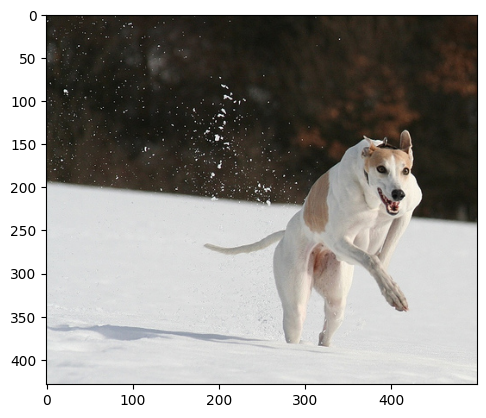

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
image_name = image_files[10]
image_id = image_name.split('.')[0]
img_path = os.path.join(extract_path, "Images", image_name)
image = Image.open(img_path)
plt.imshow(image)

In [ ]:
captions = mapping[image_id]
for caption in captions:
    print(caption)

A brown and white dog is running through the snow .
A dog is running in the snow
A dog running through snow .
a white and brown dog is running through a snow covered field .
The white and brown dog is running over the surface of the snow .


In [ ]:
def preprocess_captions(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i]
            caption = caption.lower()
            caption = caption.replace('[^A-Za-z]', '')
            caption = caption.replace('\s+', ' ')
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [ ]:
preprocess_captions(mapping)
mapping['1001773457_577c3a7d70']

['startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [ ]:
image_ids = list(mapping.keys())
len(image_ids)

8091

In [ ]:
test_len = 10
test = image_ids[len(image_ids)-test_len:]
train = image_ids[:len(image_ids)-test_len]
len(train)

8081

In [ ]:
all_captions = []
for key in train:
    for caption in mapping[key]:
        all_captions.append(caption)
len(all_captions)

40405

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)

vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in all_captions)
vocab_size

8478

In [ ]:
model = Xception()
Xception_model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
features_Xception = {}
directory = os.path.join(extract_path, 'Images')

for img_name in tqdm(os.listdir(directory)):
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(299, 299))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    feature = Xception_model.predict(image, verbose=0)
    image_id = img_name.split('.')[0]
    features_Xception[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

In [ ]:
Xception_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 149, 149, 32)         864       ['input_2[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 149, 149, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 149, 149, 32)         0         ['block1_conv1_bn[0][0]'

In [ ]:
import pickle
WORKING_DIR = 'pickle_files'
pickle.dump(features_Xception, open(os.path.join(WORKING_DIR, 'x_features.pkl'), 'wb'))

In [ ]:
with open(os.path.join(WORKING_DIR, 'x_features.pkl'), 'rb') as f:
    features = pickle.load(f)

In [ ]:
key = '1001773457_577c3a7d70'
X1, X2, y = list(), list(), list()
captions = mapping[key]
for caption in captions:
  seq = tokenizer.texts_to_sequences([caption])[0]
  for i in range(1, len(seq)):
    in_seq, out_seq = seq[:i], seq[i]
    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
    X1.append(features[key][0])
    X2.append(in_seq)
    y.append(out_seq)

In [ ]:
X1[0]

array([0.        , 1.1912764 , 0.02980349, ..., 0.        , 0.49860924,
       0.00926526], dtype=float32)

In [ ]:
X2[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1])

In [ ]:
y[0]

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [ ]:
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    X1.append(features[key][0])  # Assuming features[key][0] has shape (2048,)
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

In [ ]:
# Assuming the Xception features have shape (2048,)
image_input = Input(shape=(2048,))
image_dropout = Dropout(0.2)(image_input)
image_dense = Dense(256, activation='relu')(image_dropout)

# Sequence Input Layer
sequence_input = Input(shape=(max_length,))
sequence_embedding = Embedding(vocab_size, 256, mask_zero=True)(sequence_input)
sequence_dropout = Dropout(0.2)(sequence_embedding)
sequence_lstm = LSTM(256)(sequence_dropout)

# Decoder - Combining Image and Sequence Features
decoder_concat = add([image_dense, sequence_lstm])
decoder_dense = Dense(128, activation='relu')(decoder_concat)

# Output Layer
output = Dense(vocab_size, activation='softmax')(decoder_dense)

# Create and Compile the Model
model = Model(inputs=[image_input, sequence_input], outputs=output)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# Summary
model.summary()



Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_22 (InputLayer)       [(None, 35)]                 0         []                            
                                                                                                  
 input_21 (InputLayer)       [(None, 2048)]               0         []                            
                                                                                                  
 embedding_9 (Embedding)     (None, 35, 256)              2170368   ['input_22[0][0]']            
                                                                                                  
 dropout_18 (Dropout)        (None, 2048)                 0         ['input_21[0][0]']            
                                                                                           

In [ ]:
epochs = 20
batch_size = 32
steps = len(image_ids) // batch_size
for i in range(epochs):
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

252/252 [==============================] - 278s 1s/step - loss: 2.6676


In [ ]:
model.save('models/Xcetion.h5')

c:\Users\yadav\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from tensorflow import keras
model = keras.models.load_model('models/Xcetion.h5')

In [ ]:
def idx2word(integer, tokenizer):
  for word, index in tokenizer.word_index.items():
      if index == integer:
          return word
  return None

In [ ]:
def predict_caps(model, image, tokenizer, max_length):
  in_text = 'startseq'
  for i in range(max_length):
      sequence = tokenizer.texts_to_sequences([in_text])[0]
      sequence = pad_sequences([sequence], max_length)
      yhat = model.predict([image, sequence], verbose=0)
      yhat = np.argmax(yhat)
      word = idx2word(yhat, tokenizer)
      if word is None:
          break
      in_text += " " + word
      if word == 'endseq':
          break

  return in_text

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
# Function to print the image given image path
def show_image(image_name):
  image_id = image_name.split('.')[0]
  img_path = os.path.join(extract_path, "Images", image_name)
  image = Image.open(img_path)
  plt.imshow(image)

In [ ]:
def generate_caps(image_name):
  image_id = image_name.split('.')[0]
  show_image(image_name)
  y_pred = predict_caps(model, features[image_id], tokenizer, max_length)
  print('Predicted Caption:')
  print(y_pred)

  captions = mapping[image_id]
  print('Actual Captions:')
  for caption in captions:
      print(caption)

Predicted Caption:
startseq man is climbing rock cliff endseq
Actual Captions:
startseq beige dog with collar looks on as brown dog swims in the water endseq
startseq curly coated dog looking at another dog in the water endseq
startseq curly haired dog is standing on beach while staring at dog in deep water endseq
startseq "a white curly haired dog is wearing harness and watching another black and brown dog in the water ." endseq
startseq wooly dog on beach looks toward another dog in the water endseq


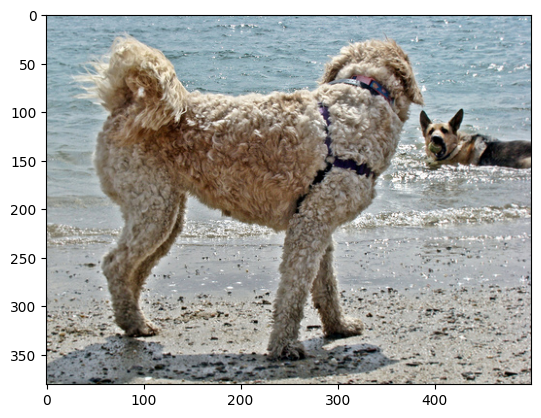

In [ ]:
generate_caps("3431860810_44277cd360.jpg")

Predicted Caption:
startseq two girls are playing in the water endseq
Actual Captions:
startseq child in pink dress is climbing up set of stairs in an entry way endseq
startseq girl going into wooden building endseq
startseq little girl climbing into wooden playhouse endseq
startseq little girl climbing the stairs to her playhouse endseq
startseq little girl in pink dress going into wooden cabin endseq


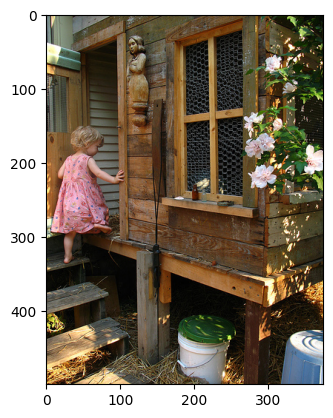

In [ ]:
generate_caps("1000268201_693b08cb0e.jpg")

In [ ]:
from nltk.translate.bleu_score import sentence_bleu
scores = []
for i in test:
  actual = mapping[i]
  predicted = predict_caps(model, features[i], tokenizer, max_length)
  scores.append(sentence_bleu(actual, predicted))

mean = sum(scores)/len(scores)
mean

0.5660497925026204